# Deep Learning Approaches Investigation

___

## Imports and Configs

In [28]:
import os
import pandas as pd
import camelot
import logging
import PyPDF2 as p
from PIL import Image
from PyPDF2.errors import PdfReadError
import pdf2image
import matplotlib.pyplot as plt

In [29]:
# CONFIGS
FILENAME_TARGET = ["Status", "Audit"]
TARGET_SENTENCE = [
    "status",
    "audit",
    "implementation",
    "recommendations",
    "prior",
    "year",
]
CANON_HEADERS = [
    "audit observation",
    "recommendations",
    "references",
    "status of implementation",
    "reasons for partial/non-implementation",
    "management action",
]
FILTER_COLUMNS = [
    "references",
    "status of implementation",
]
DATA_DIR = "extracted/"

## Clean up pdf directory

In [30]:

def clean(directory):
    """Remove duplicate files and common unwanted files from a directory.
    Args:
        directory (str): The directory to clean.
    """
    print(len(os.listdir(directory)))
    seen = set()
    for filename in os.listdir(directory):
        if filename not in seen:
            seen.add(filename)
        else: # duplicate file
            print("duplicate file: " + filename)
            os.remove(directory + filename)
            continue
        bad_names = [
            ".docx",
            ".doc",
            "Part-1",
            "Certificate",
            "Part1",
            "Independent"]
        if any(bad_name in filename for bad_name in bad_names):
            os.remove(directory + filename)
    print(len(os.listdir(directory)))
    
clean(DATA_DIR)

746
746


#### Extremely comforting to see this function work so well:

In [31]:
def find_part3_pgs(pdf_url: str):
    """
    Finds the page range of Part III of a PDF.
    Args:
        *pdf_url* (str): path to the PDF file
    Returns:
        *str*: a string representing the page range of Part III
             If no Part III is found, returns "0"

    ### Description:
    - Worst case: if there is no Part III and no target page, return "0"
    - if there is no Part III, attempt target page detection
    - if there is Part III but no Part IV, return Part III to end
    - if both Part III and Part IV are present, return Part III to Part IV
    """
    try:
        reader = p.PdfReader(pdf_url)
    except PdfReadError as e:
        print(f"Error reading file {pdf_url}: {e}")
        return (pdf_url, "Error", "Error")
    contains_piii = []
    contains_piv = []
    target_pg = []

    for i, pg in enumerate(reader.pages):
        content = pg.extract_text().lower()
        if "part iii" in content:
            contains_piii.append(i)
        if "part iv" in content:
            contains_piv.append(i)
        if all([target for target in TARGET_SENTENCE if target in content]):
            target_pg.append(i)

    # Worst case: if there is no Part III and no target page, return 0
    if len(contains_piii) == 0 and len(target_pg) == 0:
        return "0"

    # if there is no Part III, attempt target page detection
    # sometimes Part III is not labeled as such, but is still present
    # relying on the target sentence capture to find the page
    # has some problems, but is better than nothing
    if len(contains_piii) == 0 and len(target_pg) > 0:
        # if there is a target page, return first target page to end
        return (pdf_url, target_pg[0], len(reader.pages))

    # if there is Part III but no Part IV, return Part III to end
    if len(contains_piv) == 0:
        return (pdf_url, contains_piii[0], len(reader.pages))

    # if both Part III and Part IV are present, return Part III to Part IV
    part_3_start = contains_piii[-1]
    part_4_start = contains_piv[-1]
    if int(part_3_start) > int(part_4_start):
        return (pdf_url, contains_piii[0], len(reader.pages))
    elif int(part_3_start) < int(part_4_start):
        return (pdf_url, contains_piii[-1], contains_piv[-1])
    else:
        return (pdf_url, contains_piii[0], len(reader.pages))

## Page Count Investigation

In [33]:
# Calculate the page range of Part III for each PDF
# want to loop through all pdfs in the directory
def get_part3_pgs(pdf_dir):    
    lens = []
    for file in os.listdir(pdf_dir):
        if file.endswith(".pdf"):
            pdf_url = os.path.join(pdf_dir, file)
            lens.append((find_part3_pgs(pdf_url)))
        
    # Create a dataframe of the page ranges
    df = pd.DataFrame(lens, columns=["pdf_url", "start", "end"])
    df = df[df.start != "Error"]
    df['pages'] = df.end.astype(int) - df.start.astype(int)
    return df
df = get_part3_pgs(DATA_DIR)

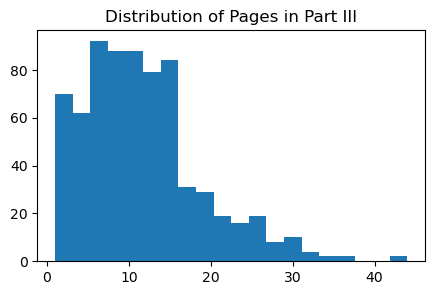

In [39]:
# Plot the distribution of pages in Part III
plt.figure(figsize=(5,3))
plt.hist(df.loc[df.pages < df.pages.quantile(.95), "pages"], bins=20)
plt.title("Distribution of Pages in Part III");

In [7]:
# No 0 pages!
df.pages.describe()

count    744.000000
mean      14.645161
std       15.620858
min        1.000000
25%        7.000000
50%       11.000000
75%       16.000000
max      166.000000
Name: pages, dtype: float64

## Bitmap Conversion

In [11]:
def convert_pages_to_bitmap(pdf_path, output_dir, page_ranges):
    """
    Convert specific pages from a PDF to bitmap images.

    :param pdf_path: str, path to the input PDF file
    :param output_dir: str, path to the directory where the output images will be saved
    :param page_ranges: list of tuples, each tuple contains the start and end page numbers (inclusive) to be converted
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load the PDF
    images = pdf2image.convert_from_path(pdf_path)

    # Iterate through the specified page ranges
    for start_page, end_page in page_ranges:
        for page_num in range(start_page - 1, end_page):  # start_page - 1 because Python uses zero-based indexing
            if 0 <= page_num < len(images):  # Check if the page number is within the valid range
                # Save the bitmap image
                file = pdf_path.split("/")[-1]
                images[page_num].save(os.path.join(output_dir, f"{file}_page_{page_num + 1}.bmp"), "BMP")

In [9]:
example = df.iloc[0]
# convert_pages_to_bitmap(example.pdf_url, "../extracted/images", [(example.start, example.end)])

___

## Camelot Retesting

In [22]:
dfs = camelot.read_pdf("extracted/12-NewLucena2013_Part3-Status_of_Implementation.pdf", pages="1-end", flavor="stream")

/Users/jackvaughan/opt/anaconda3/lib/python3.9/site-packages/camelot/parsers/stream.py:365: UserWarning: No tables found in table area 1
  warnings.warn(f"No tables found in table area {table_idx + 1}")


In [23]:
df = pd.concat([df.df for df in dfs])

In [24]:
df

,0,1,2,3,4,5
0,PART III – STATUS OF IMPLEMENTATION OF PRIOR Y...,NaN,NaN,NaN,NaN,NaN
1,27,NaN,NaN,NaN,NaN,NaN
0,,Audit Observation,Recommendation,Ref.,Managem,Status of
1,,,,,ent Action,Implementati
2,,,,,,on
...,...,...,...,...,...,...
17,,provision of the Rules,,,,items\n \nwere
18,,and Regulations\n \non,,,,"adjusted, except for"
19,,Settlement of Accounts,We recommend that the,,,items prior to cy
20,,,,34,,


---

## JPEG Conversion

In [40]:
df.head()

,pdf_url,start,end,pages
0,extracted/09-Bongabong2013_Part3-Status_of_PY'...,0,24,24
1,extracted/01-Umingan2013_Audit_Report.pdf,75,80,5
2,extracted/05-Binalbagan2013_Part3-Status_of_Im...,0,8,8
3,extracted/10-Boac2013_Part3-Status_of_PY's_Rec...,0,10,10
4,extracted/Magsaysay2013_Audit_Report.pdf,73,99,26


In [41]:
def convert_pages_to_jpeg( pdf_path, output_dir, page_ranges):
    """
    Convert specific pages from a PDF to bitmap images.

    :param pdf_path: str, path to the input PDF file
    :param output_dir: str, path to the directory where the output images will be saved
    :param page_ranges: list of tuples, each tuple contains the start and end page numbers (inclusive) to be converted
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load the PDF
    images = pdf2image.convert_from_path(pdf_path)

    # Iterate through the specified page ranges
    for start_page, end_page in page_ranges:
        for page_num in range(start_page - 1, end_page):  # start_page - 1 because Python uses zero-based indexing
            if 0 <= page_num < len(images):  # Check if the page number is within the valid range
                # Save the bitmap image
                file = pdf_path.split("/")[-1]
                images[page_num].save(os.path.join(output_dir, f"{file}_page_{page_num + 1}.jpeg"), "JPEG")

In [46]:
for i, row in df.iterrows():
    convert_pages_to_jpeg(
        row.pdf_url,
        f"extracted/images/",
        [(row.start, row.end)])

In [47]:
len(os.listdir("extracted/images"))

11099